# Projeto: Detecção de TEP (parte 4/5)

Juliano R. de Almeida

Principais referências:<br>
https://www.kaggle.com/competitions/rsna-str-pulmonary-embolism-detection/overview <br>
https://www.artmed360.com.br/curso/ultima-chamada-para-ia-cientista-de-dados<br>

#### Nesta seção serão realizadas as seguintes etapas:
- Obtenção dos labels (1 para TEP, 0 para não TEP) das imagens do conjunto de teste
- Carregamento dos modelos gerados na etapa anterior (efficientnet e mobilenet, ambos com módulo de atenção)
- Obtenção das métricas desses dois modelos para o conjunto de teste
- Ensemble dos modelos efficientnet e mobilenet a partir do cálculo da média dos valores de saída
- Obtenção das métricas para o ensemble dos modelos
- Resumo das métricas obtidas

In [1]:
# Exibe informações sobre a placa de vídeo do dispositivo
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
import keras
import os
import json
import numpy as np
import tensorflow as tf
from time import perf_counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB3,EfficientNetB4, EfficientNetB5,EfficientNetB7, Xception, ResNet50, ResNet50V2, InceptionV3
from tensorflow.keras.applications import ResNet50, Xception, EfficientNetV2B1, MobileNetV2, MobileNet, EfficientNetV2S

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from datahandler import get_dataloaders
from callback import SaveBest, MetricsCalculator
from model_utils import get_epoch_predictions



from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

# Parâmetros dos dados

Contém os parâmetros que serão fornecidos para os dados.

In [11]:
data_params = {
	"root_dir": "./",
    "csv_file": "imagens_teste_10000_cada.csv",
	"label_col": "pe_present_on_image",
	"fetch_neg_class": False,
	"path_col": "path",
	"sop_id_col": "SOPInstanceUID",
	"series_id_col": "SeriesInstanceUID",
	"study_id_col": "StudyInstanceUID",
	"split_col": "StudyInstanceUID",
	"batch_size": 1,
	"resize_dim": [224, 224],
	"window_center": [-600, 30, 400],
	"window_width": [1500, 150, 1800],   
	"normalize": False,
	"mean_dataset": [0.485, 0.456, 0.406],
	"std_dataset": [0.229, 0.224, 0.225],
	"validation_pct": 0.1,
	"test_pct": 0.8,
	"use_aug": True,
	"seed": 42
}

file_name = 'data_params.json'
with open(file_name, 'w') as json_file:
	json.dump(data_params, json_file, indent=2)

with open(file_name) as json_file:
	data_params = json.load(json_file)

dataloaders = get_dataloaders(data_params)

## Exemplo de visualização

Time to retrieve one batch of 1 images: 0.67s 


Images batch shape: (1, 224, 224, 3)
Labels batch shape: (1, 1)


Single image shape: (224, 224, 3)
Image pixel values range: [0:254]
Label: [0.], dtype: float32, shape: (1,)




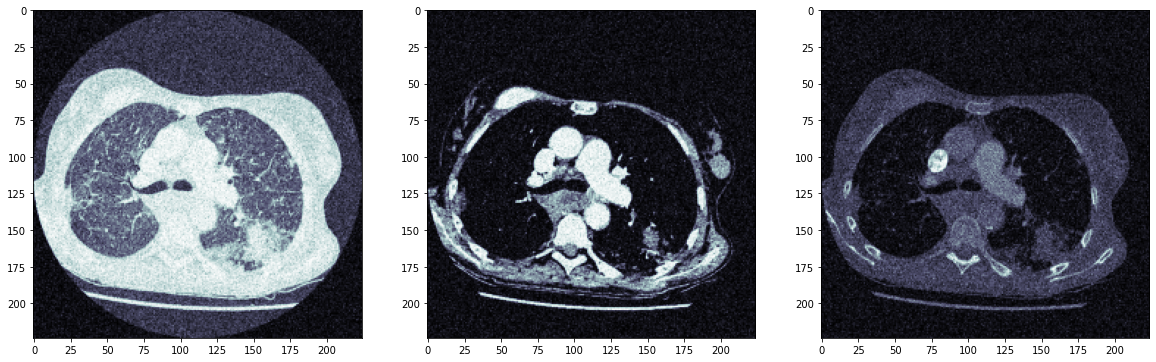

In [12]:
def print_ct_img(img):
    fig, ax = plt.subplots(1,3,figsize=(20,10))
    ax[0].imshow(img[:, :, 0], cmap="bone")
    ax[1].imshow(img[:, :, 1], cmap="bone")
    ax[2].imshow(img[:, :, 2], cmap="bone")

t0 = perf_counter()
# Get one batch from the train dataloader
batch = dataloaders['train'].__getitem__(1)
t1 = perf_counter()
print(f"Time to retrieve one batch of {data_params['batch_size']} images: {(t1-t0):.2f}s \n\n")

imgs, labels = batch
print(f"Images batch shape: {imgs.shape}")
print(f"Labels batch shape: {labels.shape}\n\n")

for i, (img, target) in enumerate(zip(imgs, labels)):
    if i == 1:
        break
    print(f"Single image shape: {img.shape}")
    print(f"Image pixel values range: [{np.amin(img)}:{np.amax(img)}]")
    print(f"Label: {target}, dtype: {target.dtype}, shape: {target.shape}\n\n")
    print_ct_img(img)

## Obtém os labels reais do conjunto

In [14]:
labels = []

for image, label in (dataloaders['test']):
    labels.append(label[0])

novo = np.vstack(labels)

# Cria uma lista simples contendo as classes verdadeiras das imagens (0 ou 1)
lista_classes_verdadeira = [int(val) for sublist in novo.tolist() for val in sublist]

In [16]:
# Quantitativos do conjunto de teste
print ("Total de imagens do conjunto de teste:", len (dataloaders['test']))
print ("Total de imagens Positivas para TEP:", lista_classes_verdadeira.count(1))
print ("Total de imagens Negativas para TEP:", lista_classes_verdadeira.count(0))

Total de imagens do conjunto de teste: 15972
Total de imagens Positivas para TEP: 7914
Total de imagens Negativas para TEP: 8058


## Carrega os modelos prontos e classifica as imagens do conjunto

In [17]:
# Carrega os modelos
model_efficientnet_att = keras.models.load_model("modelos_prontos/efficientnetb0_att.h5")
model_mobilenet_att = keras.models.load_model("modelos_prontos/mobilenet_att.h5")

# Obtem as predições dos modelos originais (saídas decimais variando de 0 a 1)
predictions_efficientnet_att = model_efficientnet_att.predict(dataloaders['test'])
predictions_mobilenet_att = model_mobilenet_att.predict(dataloaders['test'])

# Transforma as saídas decimais de cada modelo em classes (0 ou 1) 
predictions_efficientnet_att_classes = np.where(predictions_efficientnet_att > 0.5, 1, 0)
predictions_mobilenet_att_classes = np.where(predictions_mobilenet_att > 0.5, 1, 0)

# Cria uma lista simples contendo todas as classes (0 ou 1) retornadas pelos modelos originais
lista_classes_efficientnet = [val for sublist in predictions_efficientnet_att_classes.tolist() for val in sublist]
lista_classes_mobilenet = [val for sublist in predictions_mobilenet_att_classes.tolist() for val in sublist]

## Realiza o ensemble: média dos resultados dos modelos

In [18]:
data = np.array([predictions_efficientnet_att, predictions_mobilenet_att])

# Ensemble pela média dos resultados dos modelos individuais
ensemble_average = np.average(data, axis=0)

# Transforma as saídas decimais do ensemble em classes (0 ou 1) 
predictions_ensemble_classes = np.where(ensemble_average > 0.5, 1, 0)

# Cria uma lista simples contendo todas as classes (0 ou 1) retornadas pelo ensemble dos modelos
lista_classes_ensemble = [val for sublist in predictions_ensemble_classes.tolist() for val in sublist]

## Métricas e matriz de confusão para o modelo Efficientnet

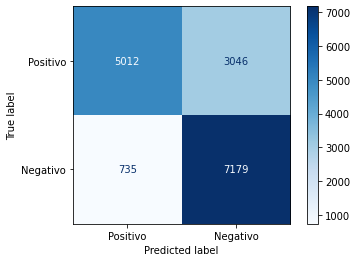

{'Binary_accuracy': 0.7632732281492612,
 'F1_score': 0.7915541099288825,
 'Auc': 0.7645585897241209,
 'Sensitivity': 0.9071266110689916,
 'Precision': 0.7021026894865525}

In [19]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#confusion_matrix(y_true, y_pred)

confusion_matrix_result = confusion_matrix(lista_classes_verdadeira, lista_classes_efficientnet)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result,  display_labels = ['Positivo', 'Negativo'])
cm_display.plot(cmap = 'Blues')
plt.show()


# Métricas
efficientnet_scores = {}
efficientnet_scores['Binary_accuracy'] = accuracy_score(lista_classes_verdadeira, lista_classes_efficientnet)
efficientnet_scores['F1_score'] = f1_score(lista_classes_verdadeira, lista_classes_efficientnet)
efficientnet_scores['Auc'] = roc_auc_score(lista_classes_verdadeira, lista_classes_efficientnet)
    
# Novas métricas
efficientnet_scores['Sensitivity'] = recall_score(lista_classes_verdadeira, lista_classes_efficientnet)
efficientnet_scores['Precision'] = precision_score(lista_classes_verdadeira, lista_classes_efficientnet)

efficientnet_scores

## Métricas e matriz de confusão para o modelo MobileNet

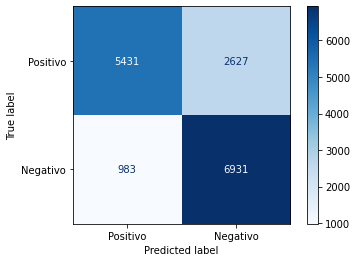

{'Binary_accuracy': 0.7739794640621087,
 'F1_score': 0.7933836996336996,
 'Auc': 0.7748891612383382,
 'Sensitivity': 0.8757897397017943,
 'Precision': 0.7251517053776941}

In [20]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#confusion_matrix(y_true, y_pred)

confusion_matrix_result = confusion_matrix(lista_classes_verdadeira, lista_classes_mobilenet)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result, display_labels = ['Positivo', 'Negativo'])
cm_display.plot(cmap = 'Blues')
plt.show()


# Métricas
mobilenet_scores = {}
mobilenet_scores['Binary_accuracy'] = accuracy_score(lista_classes_verdadeira, lista_classes_mobilenet)
mobilenet_scores['F1_score'] = f1_score(lista_classes_verdadeira, lista_classes_mobilenet)
mobilenet_scores['Auc'] = roc_auc_score(lista_classes_verdadeira, lista_classes_mobilenet)
    
# Novas métricas
mobilenet_scores['Sensitivity'] = recall_score(lista_classes_verdadeira, lista_classes_mobilenet)
mobilenet_scores['Precision'] = precision_score(lista_classes_verdadeira, lista_classes_mobilenet)

mobilenet_scores

## Métricas e matriz de confusão para o Ensemble dos modelos

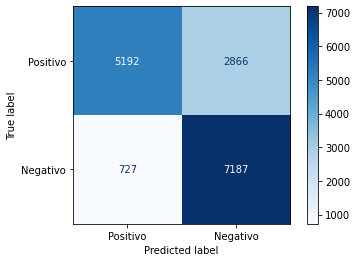

{'Binary_accuracy': 0.7750438266967192,
 'F1_score': 0.8000222630377916,
 'Auc': 0.7762330477051235,
 'Sensitivity': 0.9081374778872884,
 'Precision': 0.7149109718491993}

In [21]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#confusion_matrix(y_true, y_pred)

confusion_matrix_result = confusion_matrix(lista_classes_verdadeira, lista_classes_ensemble)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result, display_labels = ['Positivo', 'Negativo'])
cm_display.plot(cmap = 'Blues')
plt.show()

# Métricas
ensemble_scores = {}
ensemble_scores['Binary_accuracy'] = accuracy_score(lista_classes_verdadeira, lista_classes_ensemble)
ensemble_scores['F1_score'] = f1_score(lista_classes_verdadeira, lista_classes_ensemble)
ensemble_scores['Auc'] = roc_auc_score(lista_classes_verdadeira, lista_classes_ensemble)
    
# Novas métricas
ensemble_scores['Sensitivity'] = recall_score(lista_classes_verdadeira, lista_classes_ensemble)
ensemble_scores['Precision'] = precision_score(lista_classes_verdadeira, lista_classes_ensemble)

ensemble_scores

## Resumo das métricas

In [23]:
print ("-------------- Eficientnet --------------")
efficientnet_scores

-------------- Eficientnet --------------


{'Binary_accuracy': 0.7632732281492612,
 'F1_score': 0.7915541099288825,
 'Auc': 0.7645585897241209,
 'Sensitivity': 0.9071266110689916,
 'Precision': 0.7021026894865525}

In [24]:
print ("-------------- Mobilenet ----------------")
mobilenet_scores

-------------- Mobilenet ----------------


{'Binary_accuracy': 0.7739794640621087,
 'F1_score': 0.7933836996336996,
 'Auc': 0.7748891612383382,
 'Sensitivity': 0.8757897397017943,
 'Precision': 0.7251517053776941}

In [25]:
print ("-------------- Ensemble -----------------")
ensemble_scores

-------------- Ensemble -----------------


{'Binary_accuracy': 0.7750438266967192,
 'F1_score': 0.8000222630377916,
 'Auc': 0.7762330477051235,
 'Sensitivity': 0.9081374778872884,
 'Precision': 0.7149109718491993}